# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Introducción al aprendizaje profundo

### Trabajo práctico entregable 1/2 (materia completa)

- **Estudiantes:**
    - [Chevallier-Boutell, Ignacio José.](https://www.linkedin.com/in/nachocheva/)
    - Gastelu, Gabriela.
    - Santos, Maricel.
    - Spano, Marcelo.

- **Docentes:**
    - Johanna Analiz Frau (Mercado Libre).
    - Nindiría Armenta Guerrero (fyo).

---

## Librerías y dataset

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Para que todo sea reproducible
torch.manual_seed(1994)
import torch.nn as nn
import torch.optim as optim

In [6]:
try:
  import google.colab
  IN_COLAB = True

except:
  IN_COLAB = False

if not IN_COLAB:
    # Script de funciones necesarias
    from utyls_DL import *
    %load_ext autoreload
    %autoreload 2

    # Dataset
    df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
else:
    # Script de funciones necesarias
    !wget https://raw.githubusercontent.com/Cheva94/Diplo_Opt/main/3_DL/Lab1/utyls_DL.py
    from utyls_DL import *
    %load_ext autoreload
    %autoreload 2

    # Dataset
    url = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/main/3_DL/Lab1/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
    df = pd.read_csv(url)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Descripción y preprocesamiento del dataset

## Descripción

El BRFSS (Sistema de Vigilancia de Factores de Riesgo del Comportamiento) es una encuesta telefónica relacionada con la salud que los CDC (Centros para Control y prevención de Enfermedades) recopilan anualmente, desde 1984. Cada año, la encuesta recopila respuestas de más de 400.000 estadounidenses sobre conductas de riesgo relacionadas con la salud, enfermedades crónicas y el uso de servicios preventivos.

Los datos que usaremos corresponden al año 2015. El dataset original consta de 441.455 personas y tiene 330 características, las cuales son preguntas formuladas directamente a los participantes o variables calculadas en función de las respuestas de los participantes. Particularmente, el csv que utilizaremos tiene ya una limpieza, quedando 70692 respuestas, donde la mitad no tienen diabetes y la otra mitad tienen prediabetes o diabetes propiamente dicha. La variable objetivo (`Diabetes_binary`) es binaria: 0 corresponde a ausencia de diabetes y 1 corresponde a prediabetes o diabetes. Además, el dataset está balanceado y consta de 21 características. Todas las variables son numéricas (de punto flotante) y no se presentan valores nulos.

In [7]:
df.info()

print('\n\n ###-------------------------------------### \n Distribución de Diabetes_binary:')
display(df['Diabetes_binary'].value_counts())

print('\n\n ###-------------------------------------### \n Pequeña muestra del dataset:')
df.sample(5, random_state=1994)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64



 ###-------------------------------------### 
 Pequeña muestra del dataset:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
70093,1.0,1.0,1.0,1.0,26.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,10.0,4.0,4.0
3557,0.0,0.0,1.0,1.0,35.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,5.0,8.0
7758,0.0,0.0,1.0,1.0,42.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,6.0
13661,0.0,1.0,1.0,1.0,33.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,1.0,9.0,5.0,3.0
37101,1.0,1.0,1.0,1.0,32.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,20.0,15.0,1.0,0.0,9.0,4.0,8.0


Al considerar la cantidad de valores únicos presentes en cada variable, vemos que hay 14 de las 21 características son binarias.

In [8]:
nunique = df.nunique()
display(nunique)

cols_binary = [x for x in df.columns if (nunique[x] == 2) & (x != 'Diabetes_binary')]
cols_non_binary = [x for x in df.columns if (x not in cols_binary) & (x != 'Diabetes_binary')]

print(f'Hay {len(cols_binary)} features binarias y {len(cols_non_binary)} no binarias.')

Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

Hay 14 features binarias y 7 no binarias.


Considerando las variables binarias, tenemos 5 que están relativamente balanceadas (`HighBP`, `HighChol`, `Smoker`, `Fruits` y `Sex`), mientras que el resto toma valores más extremos. El significado de las variables es el siguiente:
- `HighBP`: tiene presión sanguínea alta, donde 0 es no y 1 es sí.
- `HighChol`: tiene colesterol alto, donde 0 es no y 1 es sí.
- `CholCheck`: se controló el colesterol en los últimos 5 años, donde 0 es no y 1 es sí.
- `Smoker`: fumó al menos 100 cigarrillos a lo largo de su vida, donde 0 es no y 1 es sí.
- `Stroke`: tuvo un ACV, donde 0 es no y 1 es sí.
- `HeartDiseaseorAttack`: tiene enfermedades coronarias o ataques cardíacos, donde 0 es no y 1 es sí.
- `PhysActivity`: realizó actividad física en los últimos 30 días, donde 0 es no y 1 es sí.
- `Fruits`: consume al menos 1 fruta al día, donde 0 es no y 1 es sí.
- `Veggies`: consume al menos 1 vegetal al día, donde 0 es no y 1 es sí.
- `HvyAlcoholConsump`: consumo excesivo de alcohol (más de 14 bebidas en caso de varones o más de 7 bebidas en caso de mujeres), donde 0 es no y 1 es sí.
- `AnyHealthcare`: posee algún tipo de cobertura médica, donde 0 es no y 1 es sí.
- `NoDocbcCost`: tuvo la necesidad de ir al médico en el último año, pero no fue por el costo, donde 0 es no y 1 es sí.
- `DiffWalk`: posee dificultad para caminar o subir escaleras, donde 0 es no y 1 es sí.
- `Sex`: sexo, donde 0 es mujer y 1 es varon.

HighBP                  56.345838
HighChol                52.570305
CholCheck               97.525887
Smoker                  47.527302
Stroke                   6.217111
HeartDiseaseorAttack    14.781022
PhysActivity            70.303570
Fruits                  61.179483
Veggies                 78.877384
HvyAlcoholConsump        4.272053
AnyHealthcare           95.495954
NoDocbcCost              9.391445
DiffWalk                25.273015
Sex                     45.699655
dtype: float64

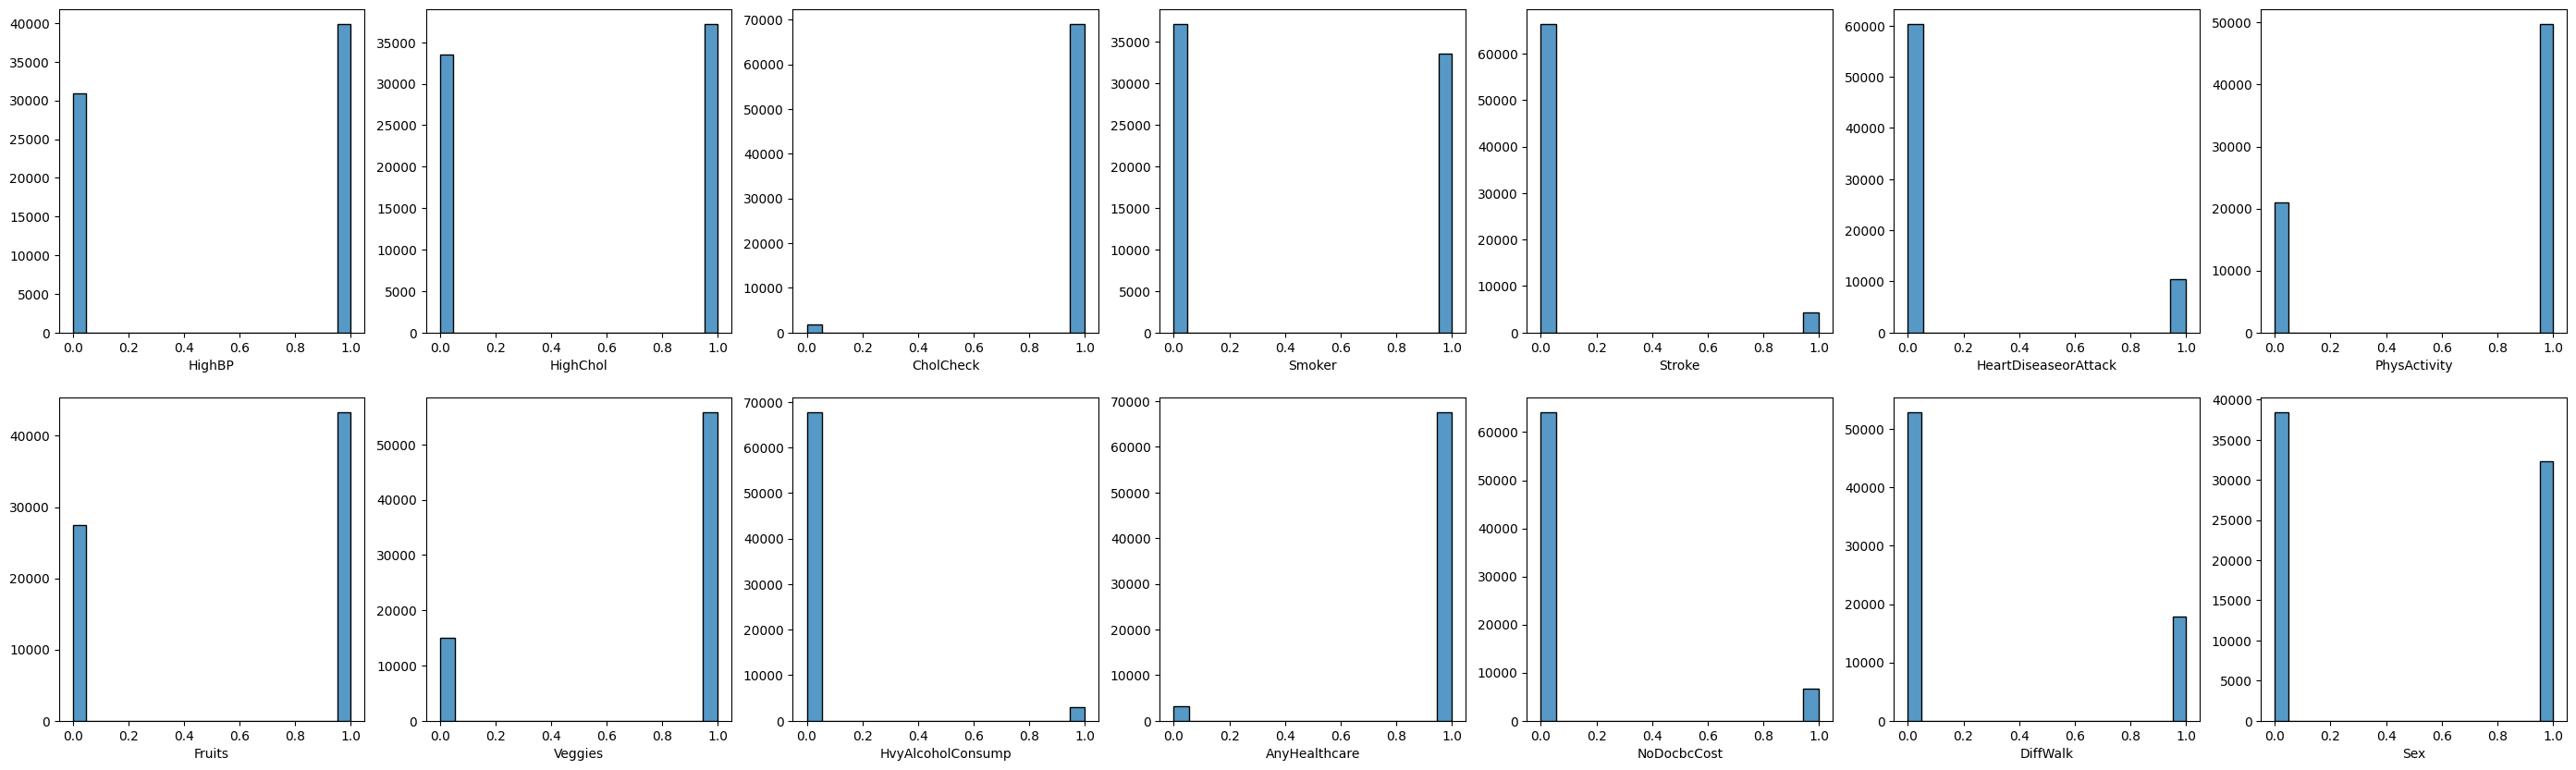

In [9]:
display(df[cols_binary].mean()*100)

_, axs = plt.subplots(2, 7, figsize=(35, 10))
for cat in range(7):
    sns.histplot(data=df, x=cols_binary[cat], ax=axs[0, cat])
    axs[0, cat].set_ylabel('')
    sns.histplot(data=df, x=cols_binary[cat+7], ax=axs[1, cat])
    axs[1, cat].set_ylabel('')

Pasando ahora a las 7 características no binarias, su significado es el siguiente:
- `BMI`: índice de masa corporal, donde debajo de 18.5 se considera por debajo del peso ideal, entre 18.5 y 24.9 es un peso saludable, de 25.0 a 29.9 es sobrepeso y por encima de 30.0 es obesidad.
- `GenHlth`: autopercepción del estado general de salud, donde 1 es excelente, 2 es muy bueno, 3 es bueno, 4 es malo y 5 es muy malo.
- `MentHlth`: cuántos de los últimos 30 días tuvo una mala salud mental.
- `PhysHlth`: cuántos de los últimos 30 días tuvo una herida o enfermedad física.
- `Age`: categorización de edades en 13 niveles, donde 1 va desde 18 hasta 24, luego toma de a 5 años hasta llegar a la categoría 13 para 80 años o más.
- `Education`: categorización de niveles de estudio en 6 niveles, donde 1 es nunca fue a la escuela o sólo al jardín y 6 es que asistió a la universidad 4 años o más.
- `Income`: categorización de niveles de ingreso en 8 niveles, donde 1 es menos de $ 10.000 dólares, luego toma de a $5.000 dólares hasta llegar a 8 para $75.000 o más.

Vemos que `MentHlth` y `PhysHlth` presentan una dispersión de datos mucho mayor a la media. Además, el rango de valores posibles es diferente para cada una de las variables. Al comparar las distribuciones para cada variable en función de la variable objetivo, se aprecian diferencias en general.

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,29.856985,2.837082,3.752037,5.810417,8.584055,4.920953,5.698311
std,7.113954,1.113565,8.155627,10.062261,2.852153,1.029081,2.175196
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,25.000000,2.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,29.000000,3.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,33.000000,4.000000,2.000000,6.000000,11.000000,6.000000,8.000000
max,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


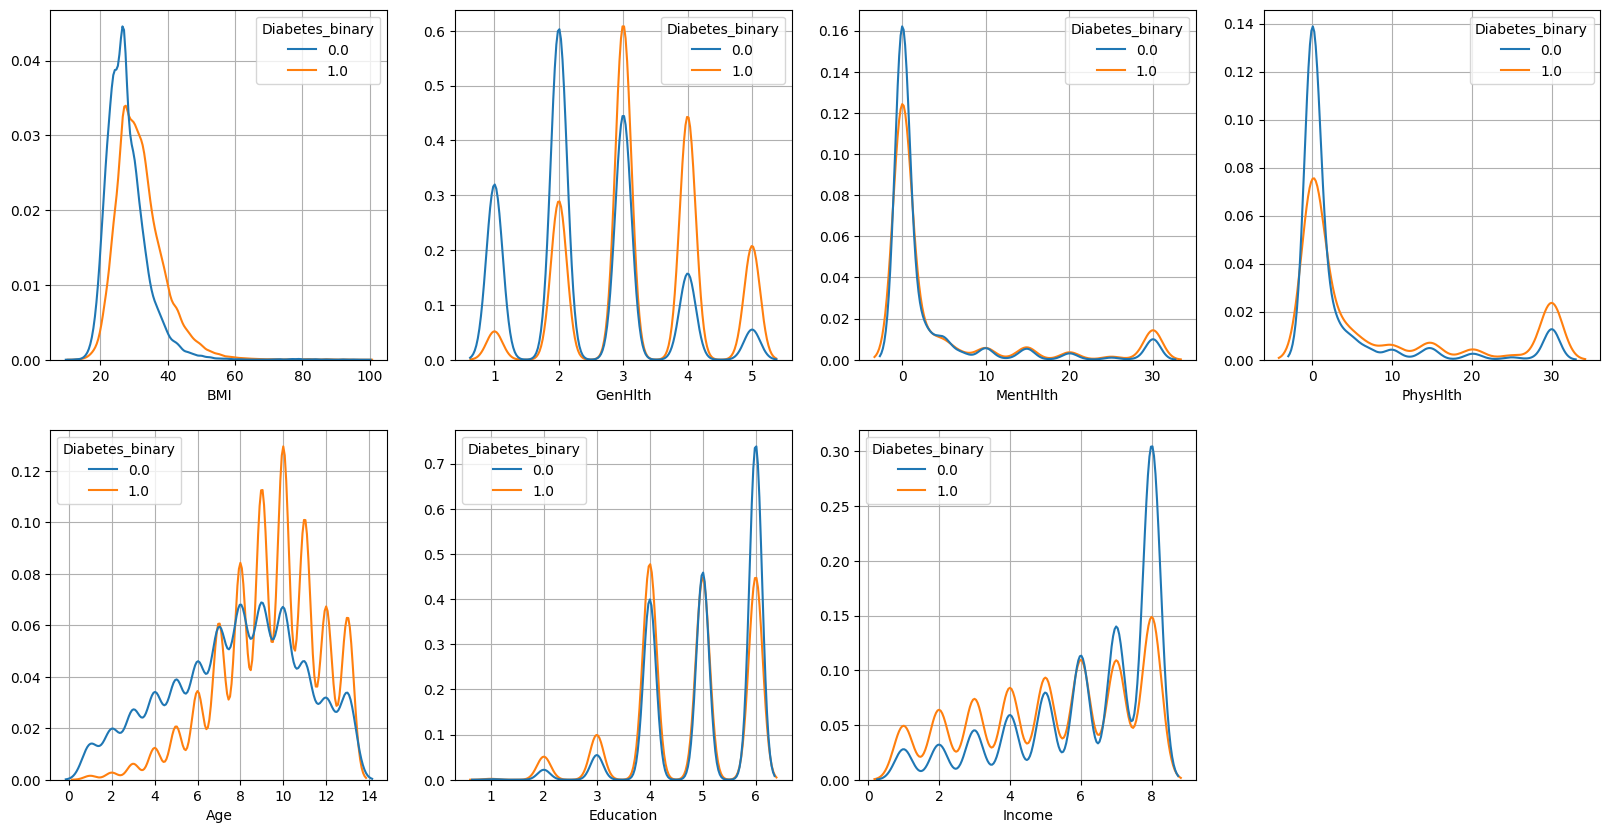

In [10]:
display(df[cols_non_binary].describe())


_, axs = plt.subplots(2, 4, figsize=(20, 10))
for cat in range(4):
    sns.kdeplot(data=df, x=cols_non_binary[cat], hue='Diabetes_binary', ax=axs[0, cat])
    axs[0, cat].set_ylabel('')
    axs[0, cat].grid()

for cat in range(3):
    sns.kdeplot(data=df, x=cols_non_binary[cat+4], hue='Diabetes_binary', ax=axs[1, cat])
    axs[1, cat].set_ylabel('')
    axs[1, cat].grid()

axs[1, 3].set_axis_off()

## Preprocesamiento

Creamos los tensores de features y target, escalando los datos entre 0 y 1 para las variables no binarias. Luego, creamos un TensorDataset a partir de los tensores de features y target. Finalmente, dividimos los datos para entrenar, validar y testear, y creamos los cargadores de datos para leer los datos por mini-batch.

In [11]:
BATCH_SIZE = 64
Data_train, Data_val, Data_test, Load_train, Load_val, Load_test = preproc(df, cols_binary, cols_non_binary, BATCH_SIZE)

n_inputs = np.prod(np.array(Data_train[0][0].shape))
n_outputs = df['Diabetes_binary'].nunique()
loss_function = nn.CrossEntropyLoss()

---
# Small MLP

## Definición del modelo

In [12]:
class SmallMLP(nn.Module):
    '''
    Modelo fully-connected con 5 capas ocultas, teniendo n_hidden neuronas en 
    cada una de ellas. Se incluye además la posibilidad de aplicar un mismo 
    dropout a todas las capas (tanto la de entrada como las ocultas).
    '''

    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function, dropout=0.0):
        super().__init__()
        self.drop0 = nn.Dropout(dropout)

        self.hidden1 = nn.Linear(n_inputs, n_hidden)
        self.activ1 = activation_function
        self.drop1 = nn.Dropout(dropout)

        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.activ2 = activation_function
        self.drop2 = nn.Dropout(dropout)

        self.hidden3 = nn.Linear(n_hidden, n_hidden)
        self.activ3 = activation_function
        self.drop3 = nn.Dropout(dropout)

        self.hidden4 = nn.Linear(n_hidden, n_hidden)
        self.activ4 = activation_function
        self.drop4 = nn.Dropout(dropout)

        self.hidden5 = nn.Linear(n_hidden, n_hidden)
        self.activ5 = activation_function
        self.drop5 = nn.Dropout(dropout)

        self.output = nn.Linear(n_hidden, n_outputs)

    def forward(self, x: torch.Tensor):
        x = self.drop0(x)

        x = self.activ1(self.hidden1(x))
        x = self.drop1(x)

        x = self.activ2(self.hidden2(x))
        x = self.drop2(x)

        x = self.activ3(self.hidden3(x))
        x = self.drop3(x)

        x = self.activ4(self.hidden3(x))
        x = self.drop4(x)

        x = self.activ5(self.hidden3(x))
        x = self.drop5(x)

        x = self.output(x)  # Output Layer
        return x

## Baseline

In [14]:
EPOCHS = 100

baseline_param = {
    'nH': 3,
    'AF': nn.Sigmoid(),
    'GD': optim.SGD,
    'LR': 0.1,
    'Mom': 0.9
}

In [36]:
baseline_exp = []
# Instanciamos el modelo
model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], baseline_param['AF'])
# Definimos el optimizador
optimizer = baseline_param['GD'](model.parameters(), lr=baseline_param['LR'], momentum=baseline_param['Mom'])
# Corremos el baseline
experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
baseline_exp.append(experiment)

Begin training...


	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 3.99 min
Completed training in 100 batch:  Training Loss is:  0.6953 - Validation Loss is:  0.6966 - Accuracy is:  0.5062950912434574 - F1 is:  0.3361


Pérdidas:


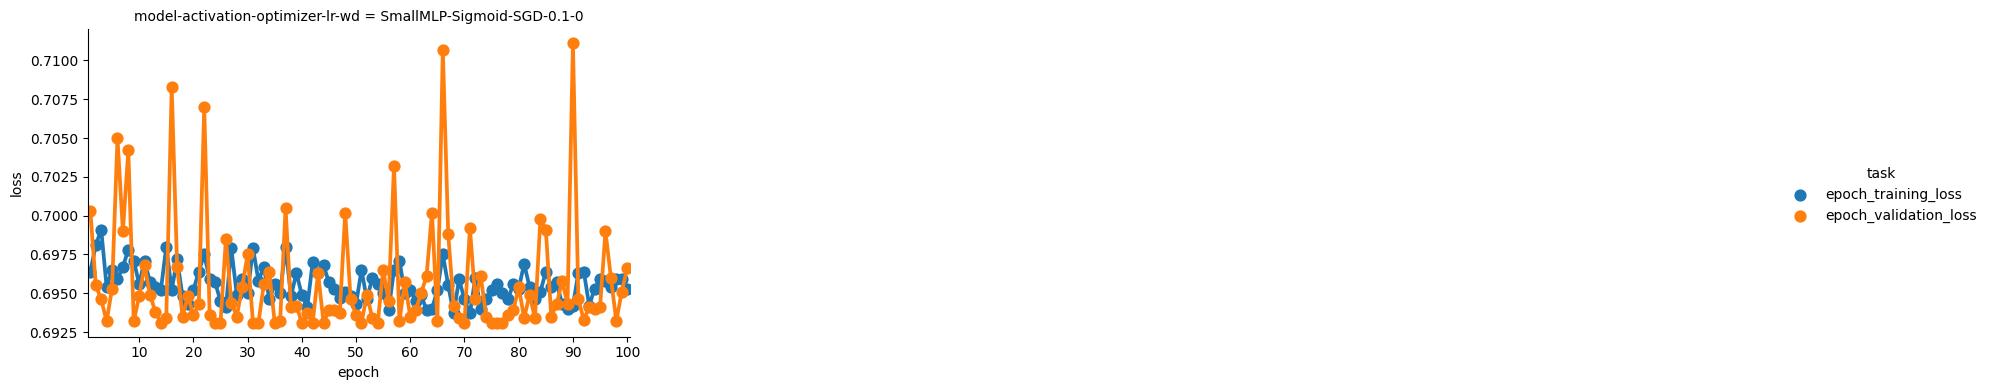


Métricas:


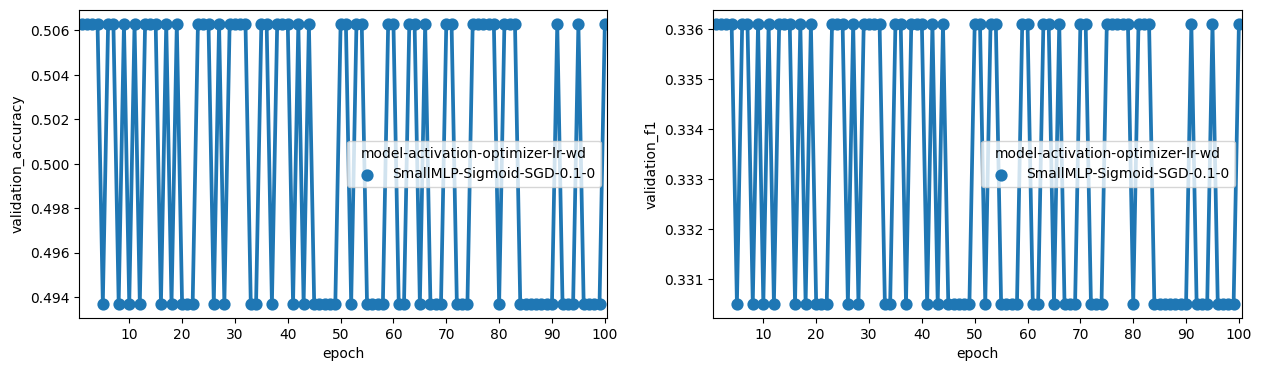

In [37]:
# plot_results(EPOCHS, f'SmallMLP/Baseline_Epocas-{EPOCHS}.csv', baseline_exp)
plot_results(100, 'SmallMLP/Baseline_Epocas-100.csv')

Nuestro baseline con esta red pequeña (5 capas ocultas con 3 neuronas por capa), es bastante pobre. Por un lado, el costo de entrenamiento es prácticamente constante y, además, el costo de validación es muy errático. Esto se ve reflejando en las métricas, ya que osculan a lo largo de todas las épocas, sin alncazar alguna estabilización.

## Estudio de la función de activación

In [15]:
activation_functions = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU()
}

In [38]:
ActFunc_Exps1 = []

for key in activation_functions.keys():
    print(f'\n\n Corriendo con {key}')
    model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], activation_functions[key])
    optimizer = baseline_param['GD'](model.parameters(), lr=baseline_param['LR'], momentum=baseline_param['Mom'])
    experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
    ActFunc_Exps1.append(experiment)



 Corriendo con Sigmoid
Begin training...


	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.27 min
Completed training in 100 batch:  Training Loss is:  0.6976 - Validation Loss is:  0.6939 - Accuracy is:  0.49370490875654266 - F1 is:  0.3305


 Corriendo con Tanh
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.15 min
Completed training in 100 batch:  Training Loss is:  0.5056 - Validation Loss is:  0.5202 - Accuracy is:  0.7299476587919084 - F1 is:  0.7291


 Corriendo con ReLU
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la

Pérdidas:


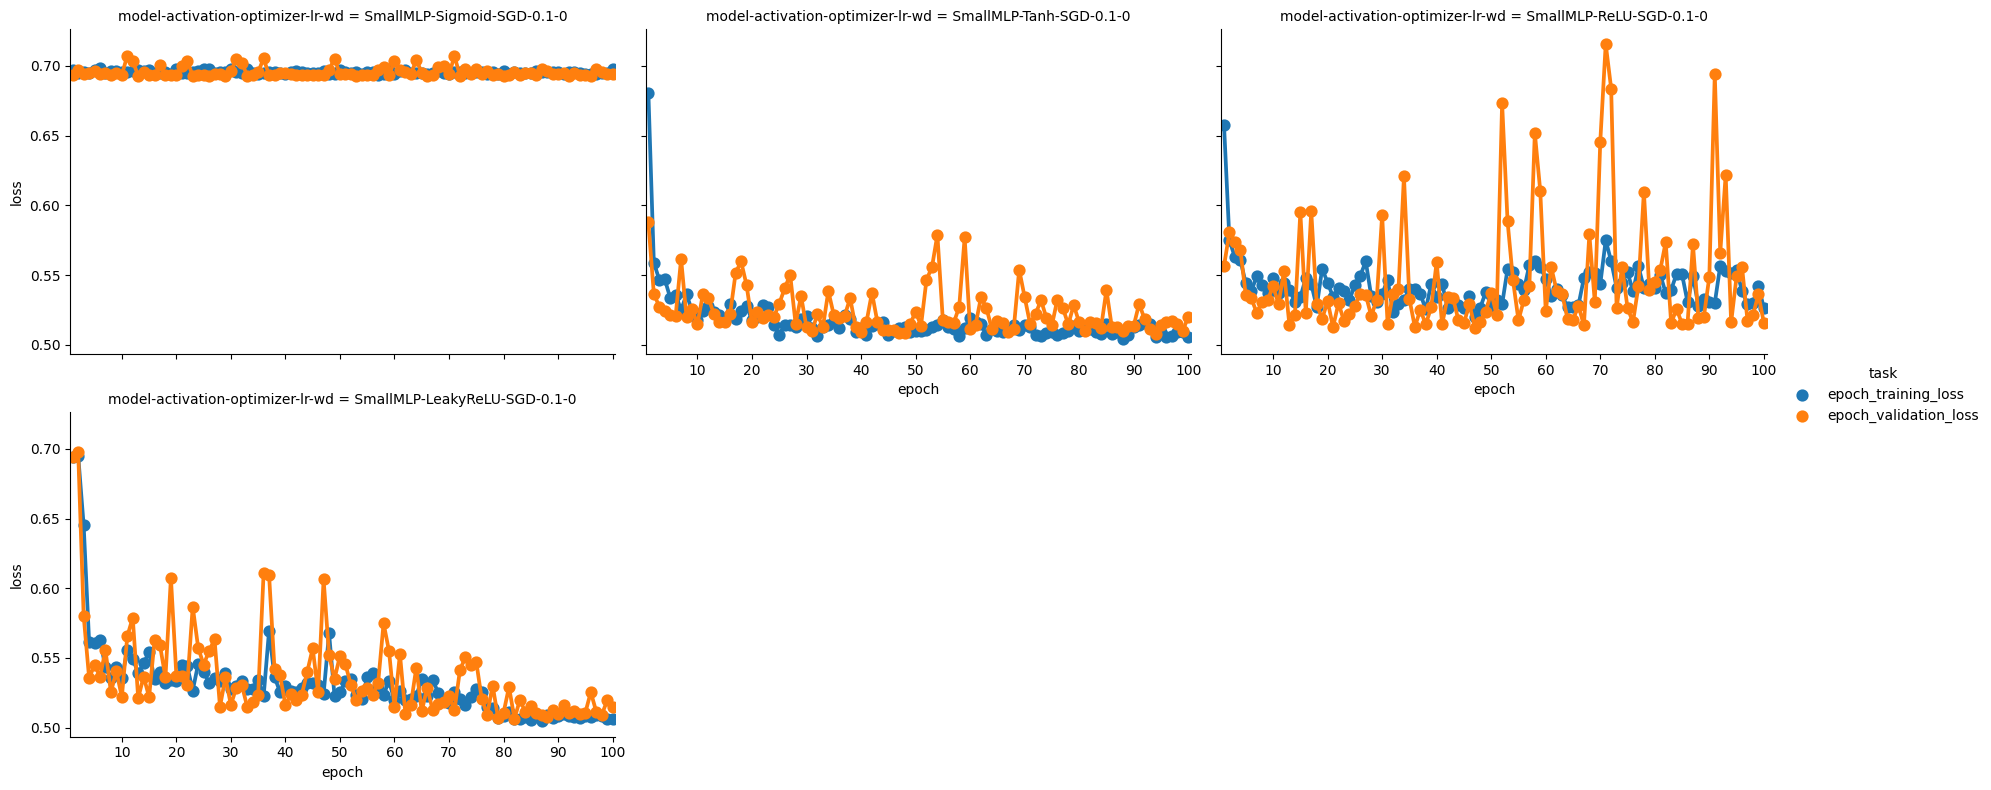


Métricas:


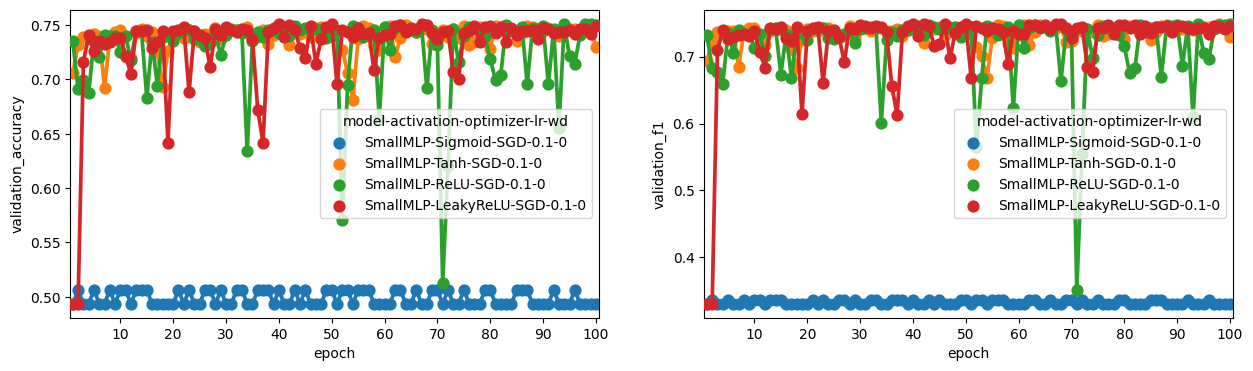

In [39]:
# plot_results(EPOCHS, f'SmallMLP/ActFunc_Epocas-{EPOCHS}.csv', ActFunc_Exps1)
plot_results(100, 'SmallMLP/ActFunc_Epocas-100.csv')

Lo primero que analizamos es qué ocurre al variar la función de activación. La sigmoide es la función de activación utilizada en el baseline. Vemos que las otras 3 mejoran bastante respecto a la sigmoide. Enfocándonos en las 3 nuevas funciones de activación, tenemos que la ReLU tiene bastantes saltos en el costo de validación, correspondiéndose con saltos en las métricas, mientras que la Tanh resulta ser la de mayor estabilidad, alcanzando dicha estabilidad en una menor cantidad de épocas (~30) respecto a LeakyReLU (~80). También se observa una mejor correspondencia entre los costes de entrenamiento y validación para Tanh que para LeakyReLU. Decidimos quedarnos con Tanh a pesar de que ReLU y LeakyReLU alcancen métricas un 2% mayores.

## Estudio del optimizador

In [16]:
ActFunc_best1 = nn.Tanh()
optims = [optim.SGD, optim.Adagrad, optim.RMSprop, optim.Adam]

In [40]:
Optim_Exps1 = []

for opt in optims:
    print(f'\n\n Corriendo con {opt}')
    model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], ActFunc_best1)
    if opt == optim.SGD:
        optimizer = opt(model.parameters(), lr=baseline_param['LR'], momentum=baseline_param['Mom'])
    else:
        optimizer = opt(model.parameters(), lr=baseline_param['LR'])
    experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
    Optim_Exps1.append(experiment)



 Corriendo con <class 'torch.optim.sgd.SGD'>
Begin training...


	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.05 min
Completed training in 100 batch:  Training Loss is:  0.5103 - Validation Loss is:  0.5146 - Accuracy is:  0.7449427075965483 - F1 is:  0.7441


 Corriendo con <class 'torch.optim.adagrad.Adagrad'>
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.31 min
Completed training in 100 batch:  Training Loss is:  0.4966 - Validation Loss is:  0.5087 - Accuracy is:  0.7448012448719762 - F1 is:  0.7442


 Corriendo con <class 'torch.optim.rmsprop.RMSprop'>
Begin training...
	Voy por la época 10! :)
	Voy por la época 20!

Pérdidas:


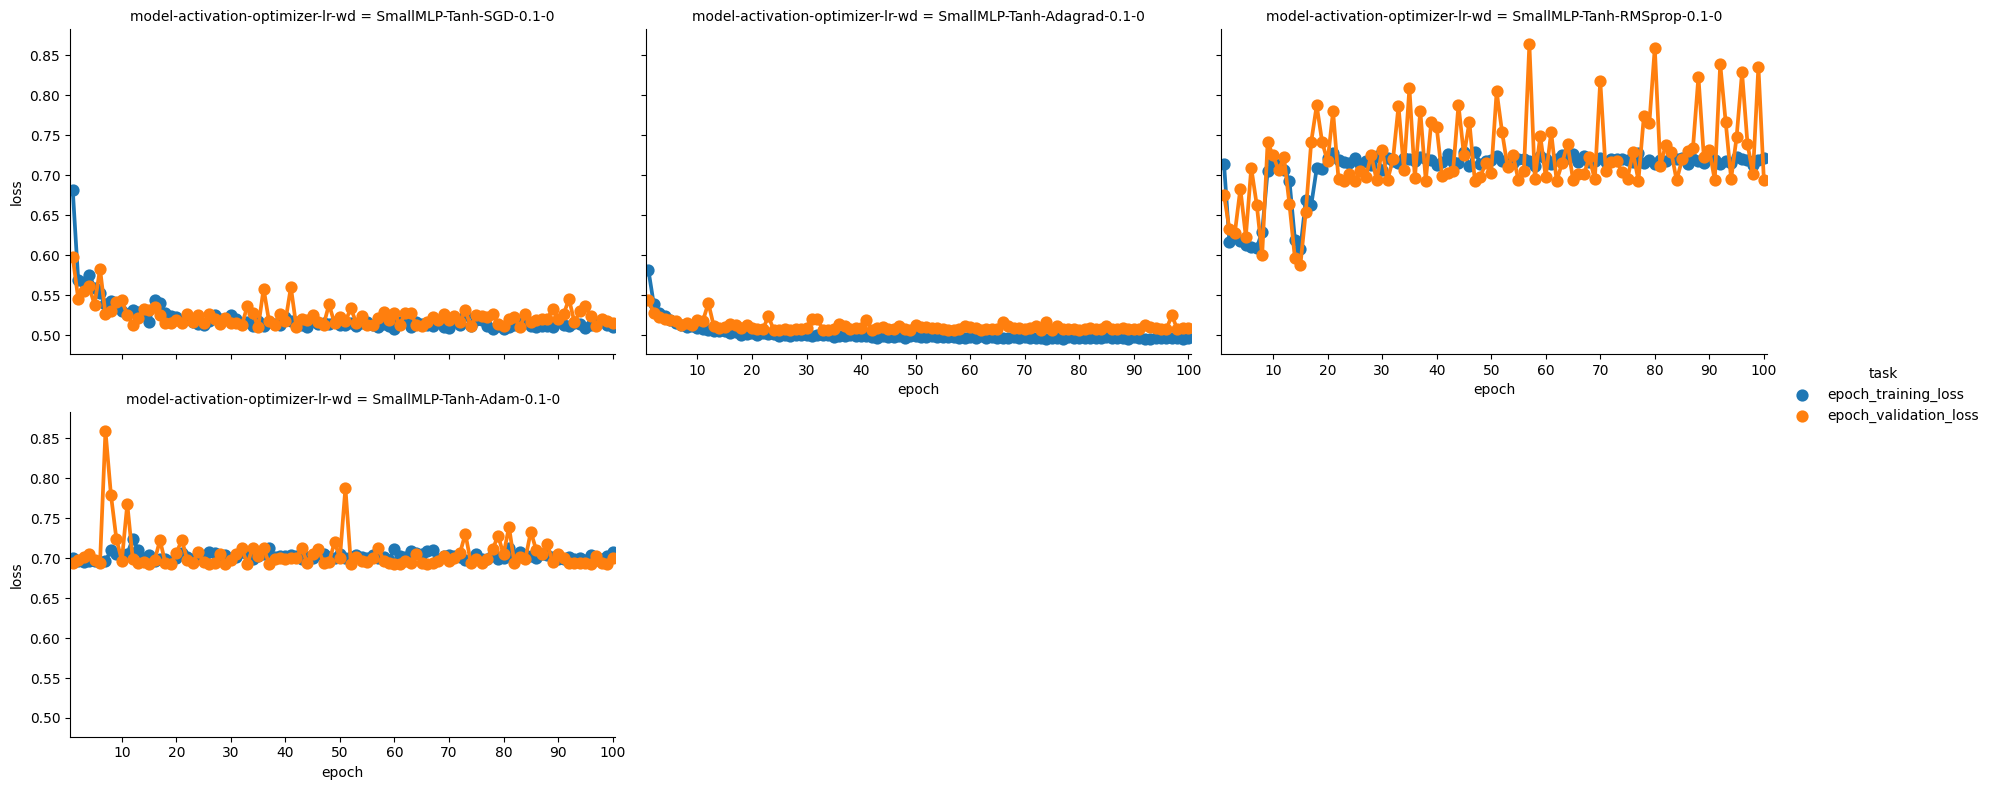


Métricas:


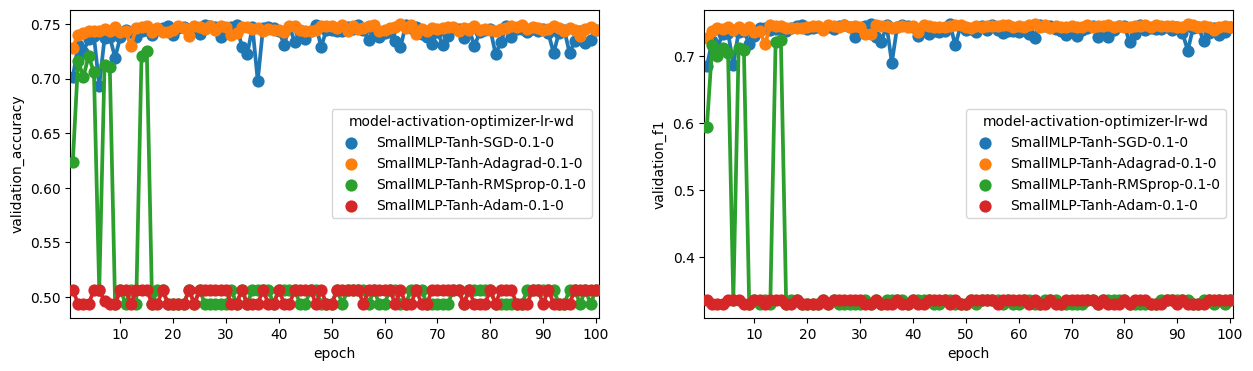

In [41]:
plot_results(EPOCHS, f'SmallMLP/Optimizadores_Epocas-{EPOCHS}.csv', Optim_Exps1)
# plot_results(100, 'SmallMLP/Optimizadores_Epocas-100.csv')

## Estudio de la tasa de aprendizaje

In [17]:
Optim_best1 = optim.Adagrad
alpha = [0.1, 0.01, 0.001, 0.0001]

In [42]:
LR_Exps1 = []

for LR in alpha:
    print(f'\n\n Corriendo con {LR}')
    model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], ActFunc_best1)
    if Optim_best1 == optim.SGD:
        optimizer = Optim_best1(model.parameters(), lr=LR, momentum=baseline_param['Mom'])
    else:
        optimizer = Optim_best1(model.parameters(), lr=LR)
    experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
    LR_Exps1.append(experiment)



 Corriendo con 0.1
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.39 min
Completed training in 100 batch:  Training Loss is:  0.4982 - Validation Loss is:  0.5082 - Accuracy is:  0.748054887537134 - F1 is:  0.7455


 Corriendo con 0.01
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.35 min
Completed training in 100 batch:  Training Loss is:  0.5122 - Validation Loss is:  0.5152 - Accuracy is:  0.7440939312491158 - F1 is:  0.7425


 Corriendo con 0.001
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :

Pérdidas:


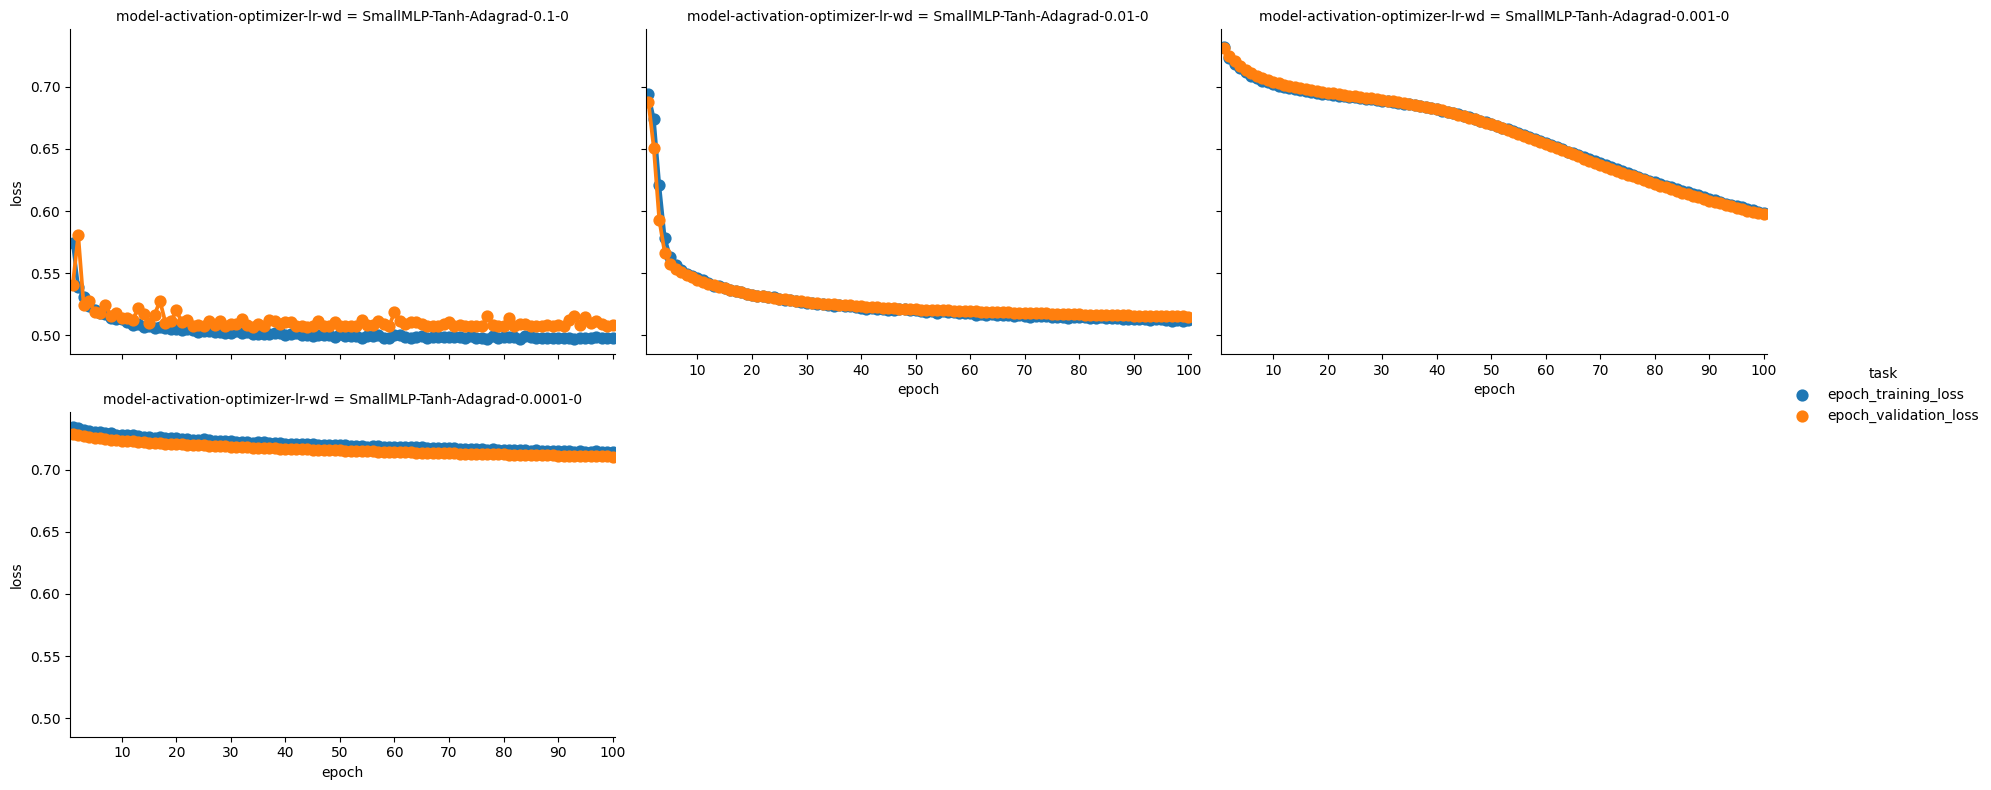


Métricas:


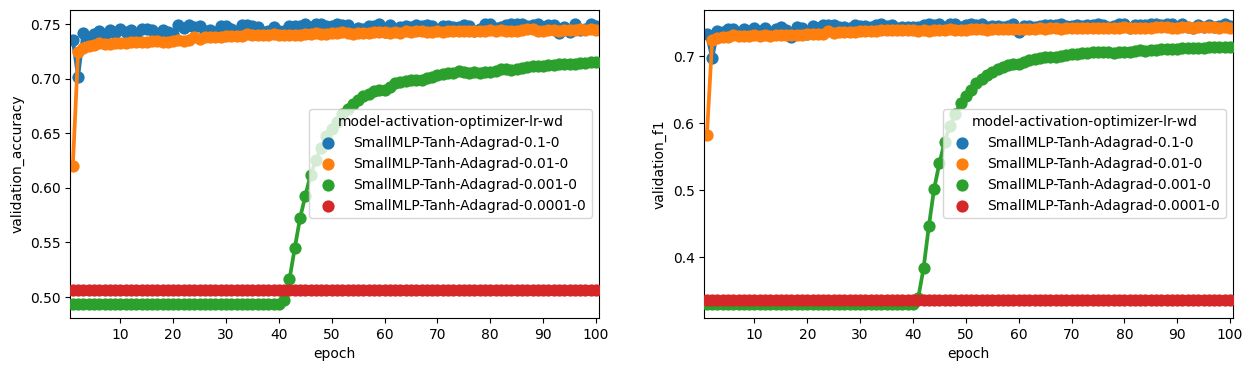

In [43]:
plot_results(EPOCHS, f'SmallMLP/LR_Epocas-{EPOCHS}.csv', LR_Exps1)

## Estudio del tamaño de lote

In [18]:
LR_best1 = 0.1
batches = [32, 64, 128]

In [44]:
Batch_Exps1 = []

for batch in batches:
    print(f'\n\n Corriendo con {batch}')
    Data_train, Data_val, Data_test, Load_train, Load_val, Load_test = preproc(df, cols_binary, cols_non_binary, batch)

    model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], ActFunc_best1)
    if Optim_best1 == optim.SGD:
        optimizer = Optim_best1(model.parameters(), lr=LR_best1, momentum=baseline_param['Mom'])
    else:
        optimizer = Optim_best1(model.parameters(), lr=LR_best1)
    experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
    Batch_Exps1.append(experiment)



 Corriendo con 32
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 4.05 min
Completed training in 100 batch:  Training Loss is:  0.4937 - Validation Loss is:  0.5206 - Accuracy is:  0.7450841703211204 - F1 is:  0.7449


 Corriendo con 64
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 2.34 min
Completed training in 100 batch:  Training Loss is:  0.5054 - Validation Loss is:  0.5024 - Accuracy is:  0.7595133682274721 - F1 is:  0.7577


 Corriendo con 128
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	V

Pérdidas:


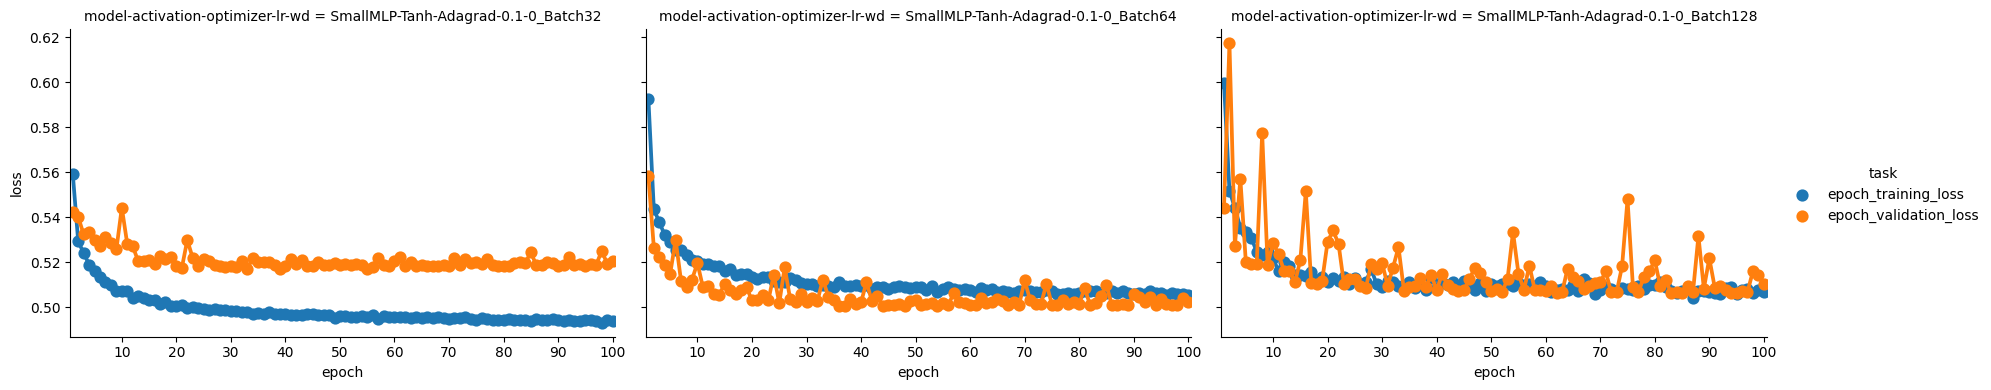


Métricas:


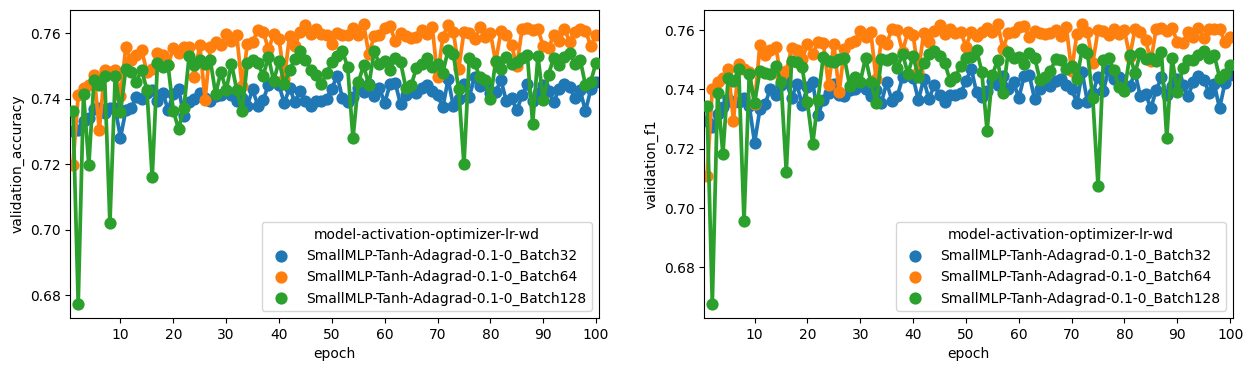

In [48]:
# plot_results(EPOCHS, f'SmallMLP/Batch_Epocas-{EPOCHS}.csv', Batch_Exps1)
plot_results(100, 'SmallMLP/Batch_Epocas-100.csv')

## Estudio del dropout

In [21]:
Batch_best1 = 64
Data_train, Data_val, Data_test, Load_train, Load_val, Load_test = preproc(df, cols_binary, cols_non_binary, Batch_best1)

dropOuts = [0.0, 0.05, 0.1] # [0.2, 0.4, 0.6]

In [22]:
Drop_Exps1 = []

for drop in dropOuts:
    print(f'\n\n Corriendo con {drop}')
    model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], ActFunc_best1, dropout=drop)
    if Optim_best1 == optim.SGD:
        optimizer = Optim_best1(model.parameters(), lr=LR_best1, momentum=baseline_param['Mom'])
    else:
        optimizer = Optim_best1(model.parameters(), lr=LR_best1)
    experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
    Drop_Exps1.append(experiment)



 Corriendo con 0.0
Begin training...


	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 3.23 min
Completed training in 100 batch:  Training Loss is:  0.5 - Validation Loss is:  0.5144 - Accuracy is:  0.7421134531051068 - F1 is:  0.7418


 Corriendo con 0.05
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la época 50! :)
	Voy por la época 60! :)
	Voy por la época 70! :)
	Voy por la época 80! :)
	Voy por la época 90! :)
	Terminé! :D >>> WallTime = 3.44 min
Completed training in 100 batch:  Training Loss is:  0.5417 - Validation Loss is:  0.5233 - Accuracy is:  0.7411232140331023 - F1 is:  0.7406


 Corriendo con 0.1
Begin training...
	Voy por la época 10! :)
	Voy por la época 20! :)
	Voy por la época 30! :)
	Voy por la época 40! :)
	Voy por la époc

Pérdidas:


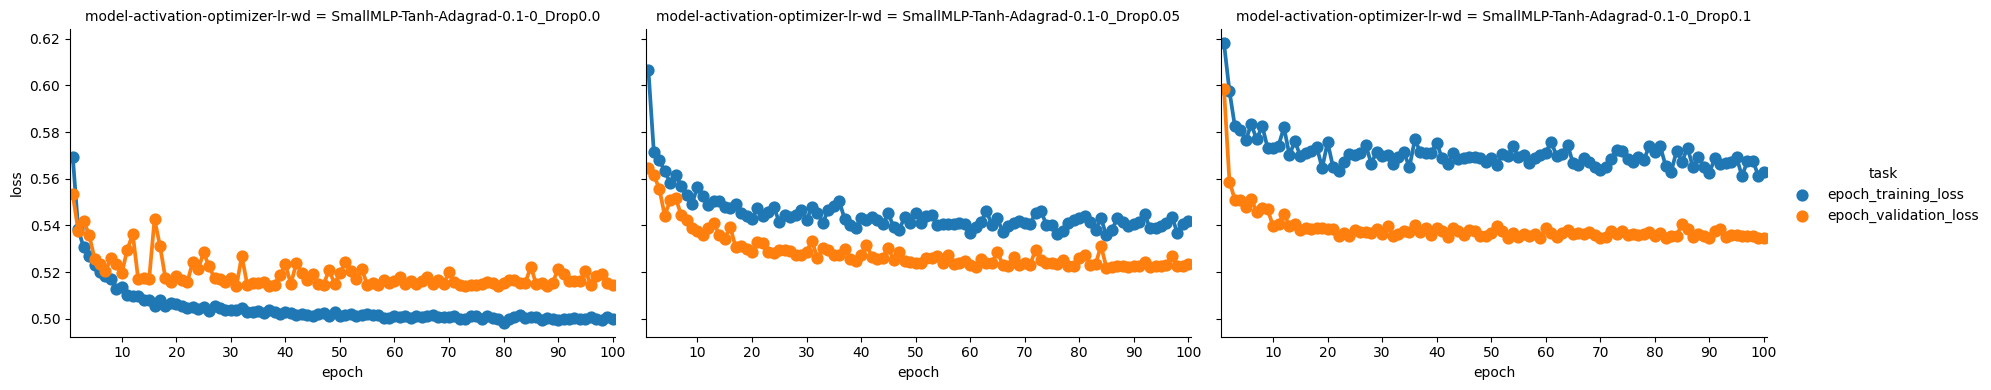


Métricas:


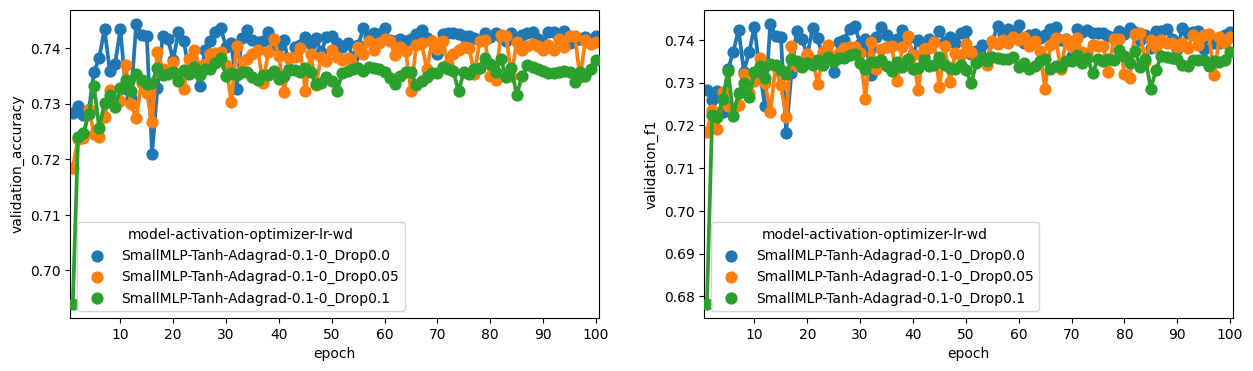

In [24]:
# plot_results(EPOCHS, f'SmallMLP/Drop_Epocas-{EPOCHS}.csv', Drop_Exps1)
# plot_results(100, 'SmallMLP/Drop_Epocas-100.csv')
# plot_results(EPOCHS, f'SmallMLP/Drop_Epocas-{EPOCHS}_new.csv', Drop_Exps1)
plot_results(100, 'SmallMLP/Drop_Epocas-100_new.csv')

---
# Comparación final y conclusiones

Acá comparar la mejor configuración de los 3 modelos elegidos y aplicarlos al conjunto de test? O ir testeando al final de cada modelo?